# Assignment 1
Tarun Kumar Singhal - 1003599448


## Sentiment Analysis of Tweets 

In this notebook, sentiment analysis of tweets were perfromed to gain any potential insights into the political sentiment of the Canadian electorate with respect to the major political parties participating in the 2015 federal election.

In [1]:
# install packages
!pip install nltk
!pip install pandas
!pip install numpy
!pip install sklearn
!pip install matplotlib

# download datasets
import nltk
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# import required packages
import pandas as pd
import numpy as np
import re 
import html
import matplotlib.pyplot as plt 
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier

try:
    import seaborn as sns
except err:
    !pip install seaborn
    import seaborn as sns
    
try:
    from wordcloud import WordCloud
except err:
    !pip install wordcloud
    from wordcloud import WordCloud
    
# turn on inline plotting of graphs
%matplotlib inline

[nltk_data] Downloading package stopwords to /Users/tks/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /Users/tks/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/tks/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
sns.set_style('whitegrid')

To get started, first read read tweets data from text file and remove empty lines from raw file

In [3]:
# read tweets string data from file
tweets = open('unclassified_tweets.txt','r', encoding='utf-8').read()

# split tweets by \n
tweets = tweets.split('\n')

# remove empty strings
tweets = [str for str in tweets if str]

# create a dataframe with tweets data
ucTweets = pd.DataFrame ({'tweet': tweets})

### Part 1. Data Cleaning

1. Prepare two database 
    - Apostrohe Contractions List
    - Stopwords list from NLTK Package
2. Clean tweet one by one.
    - convert ASCII characters
    - remove HTML Tags
    - convert to lowercase
    - convert ('s, 're) to (is, are) {Apostrohe expansion}
    - remove url using regex
    - remove stopwords
    - remove single characters
    - remove unnecessary puncuation and spaces
    - trim endspaces
   
    

In [4]:
# apostrohe contractions list 
# source : https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions
APOSLIST = [
    ["'s", "is"],
    ["'re", "are"],
    ["n't", "not"],
    ["'m", "am"],
    ["'ve", "have"], 
    ["'ll", "will"],
    ["'d", "did"],
    ["'tis", "it is"],
    ["'twas", "it was"]
]

# read stops words list 
STOPWORDS = set(stopwords.words('english'))

# cleanup tweets
def cleanupTweet(tweet): 

    # convert ASCII characters  
    tweet = html.unescape(tweet) 
    tweet = str(tweet)
    tweet = tweet.replace('\ufeff', '')

    # convert into lower text
    tweet = tweet.lower() 

    # remove the HTML tags from each tweet
    tweet = re.sub(re.compile('<.*?>'), '', tweet)

    # apostohe removals
    tweet = re.sub(re.compile('(’|`)'), "'", tweet)
    for apos in APOSLIST:  
        tweet = (" " + apos[1]).join(tweet.split(apos[0])) 

    # clean urls from tweet [source: https://www.regexpal.com/93652]
    tweetWords = re.split('(\s+)', tweet)
    urlRegex = r'^(http:\/\/www\.|https:\/\/www\.|http:\/\/|https:\/\/)?[a-z0-9\-\—]+([\.]{1}[a-z0-9]+)*\.[a-z]{2,5}(:[0-9]{1,5})?(\/.*)?$'
    tweetWords = [re.sub(re.compile(urlRegex), '', tw) for tw in tweetWords]
    
    # remove words with less than or equal to 1 characters
    tweetWords = [i for i in tweetWords if len(i) > 1]
    
    # stop words
    tweet = ' '.join(i for i in tweetWords if i not in STOPWORDS)

    # remove unnecessary puncuation and spaces 
    tweet = re.sub(re.compile('((\.)+|\.\s|…)+'), ' ', tweet) 
    tweet = re.sub(re.compile('(!|;|\"|\?|:|-|—|,|‘|\|~|=|\'|/|\)|\()'), ' ', tweet)
    tweet = re.sub(re.compile('\s+'), ' ', tweet) 
    
    # return
    return tweet.strip() 
 
    
# cleanup tweets
ucTweets['tweet'] = ucTweets['tweet'].apply(cleanupTweet)

# Save to File 
ucTweets.to_csv('cleanedTweets.csv', sep='\t', encoding='utf-8')

# debug
ucTweets.head()

,tweet
0,living dream #cameraman #camera #cameraception...
1,justin #trudeau reasons thanksgiving today mon...
2,@themadape butt butt we allergic latex makes u...
3,massive explosions peace march #turkey 30 kill...
4,#mulcair suggests bad blood #trudeau #ready4ch...


### Part 2. Exploratory analysis

Prepare a database of hashtags/words associated with each party. We have considered 4 main parties for our analysis.
 - Conversative Party
 - Liberal Party
 - Non Democratic Party
 - Green Party
 
 source: http://politwitter.ca/page/canadian-politics-hash-tags

In [5]:
# liberal & conservative database
liberalList = ['justin', 'trudeau', 'justintrudeau', 'liberal', '#lpc']
conservativeList = ['harper', 'conservative', '#cpc', '#pttory','stephen']
democraticList = ['mulcair', 'democratic', '#ndp', '#ptndp']
greenList = ['elizabethmay', '#ptgreen', '#gpc', '#greens']

Once, the database of keywords hasbeen finalized then, look for those keywords in each tweet. 
If there is match, then assign frequency of matches corresponding to that political party.

    for e.g. "#trudeau should win" will be assigned to liberal party with freq 1 (i.e. isLiberal is equal to 1)



In [6]:
# has word in tweet  
def isWordExistInTweet(tweetWords, wordList):
    cnt = 0
    for w in tweetWords:
        for l in wordList:
            if(l in w): 
                cnt += 1
    return cnt


# add isLiberal, isConservative, sentimentVal
ucTweets['isLiberal'] = ucTweets['tweet'].apply(lambda x: isWordExistInTweet(x.split(), liberalList))
ucTweets['isConservative'] = ucTweets['tweet'].apply(lambda x: isWordExistInTweet(x.split(), conservativeList))
ucTweets['isDemocratic'] = ucTweets['tweet'].apply(lambda x: isWordExistInTweet(x.split(), democraticList))
ucTweets['isGreen'] = ucTweets['tweet'].apply(lambda x: isWordExistInTweet(x.split(), greenList))

# debug
ucTweets.head()

,tweet,isLiberal,isConservative,isDemocratic,isGreen
0,living dream #cameraman #camera #cameraception...,0,0,1,0
1,justin #trudeau reasons thanksgiving today mon...,2,0,0,0
2,@themadape butt butt we allergic latex makes u...,0,0,0,0
3,massive explosions peace march #turkey 30 kill...,0,0,0,0
4,#mulcair suggests bad blood #trudeau #ready4ch...,1,0,2,0


After determining the frequency corresponding to each party, there can be the cases where a specific tweet is mapped to multiple parties. To overcome this, add another column where if a tweet is mapped more than 1 party, then check the frequency of occurence to decide the party. If the frequency is same, then assign it to 'None'


In [7]:
# get Political Party of the tweet
def getPoliticalParty(isLiberal, isConservative, isDemocratic, isGreen):
    
    # assign var
    t1 = [isLiberal, isConservative, isDemocratic, isGreen]
    l1 = ['Liberal', 'Conservative', 'Democratic', 'Green']
    maxIdx = []
    m = max(t1)
    
    # get num of max indexes
    for idx, val in enumerate(t1):
        if(val == m):
            maxIdx.append(idx)
            
    # define party 
    if(len(maxIdx) == 1):
        return l1[maxIdx[0]]
    else: 
        return 'None' 

# getFinal Party 
ucTweets['politicalParty'] = ucTweets.apply(lambda x: getPoliticalParty(x['isLiberal'], x['isConservative'], x['isDemocratic'], x['isGreen']), axis=1)

#debug
ucTweets.head()

,tweet,isLiberal,isConservative,isDemocratic,isGreen,politicalParty
0,living dream #cameraman #camera #cameraception...,0,0,1,0,Democratic
1,justin #trudeau reasons thanksgiving today mon...,2,0,0,0,Liberal
2,@themadape butt butt we allergic latex makes u...,0,0,0,0,None
3,massive explosions peace march #turkey 30 kill...,0,0,0,0,None
4,#mulcair suggests bad blood #trudeau #ready4ch...,1,0,2,0,Democratic


Plot the popularity of political party based on number of tweet associated with it. 

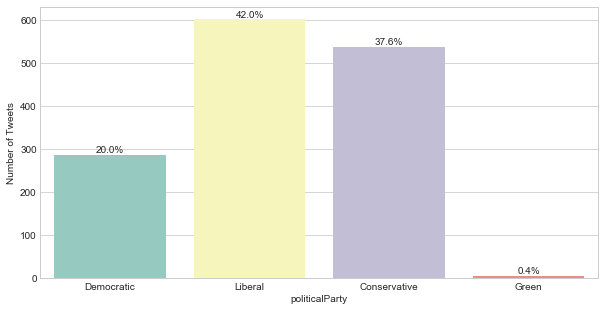

In [8]:
# plot bar chart  
fig, axis1 = plt.subplots(1,1,figsize=(10,5))

ax = sns.countplot(x='politicalParty', data=ucTweets[(ucTweets['politicalParty'] != "None")], ax=axis1, palette="Set3")
ax.set_ylabel('Number of Tweets')
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/len(ucTweets[(ucTweets['politicalParty'] != "None")])), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text

It can be clearly seen that 'Conservative' and 'Liberal' parties are most talked about during the 2015 election. 'Green Party' is the least talked about.


Now, we will try to visualize some characteristics of unclassified and classified data.

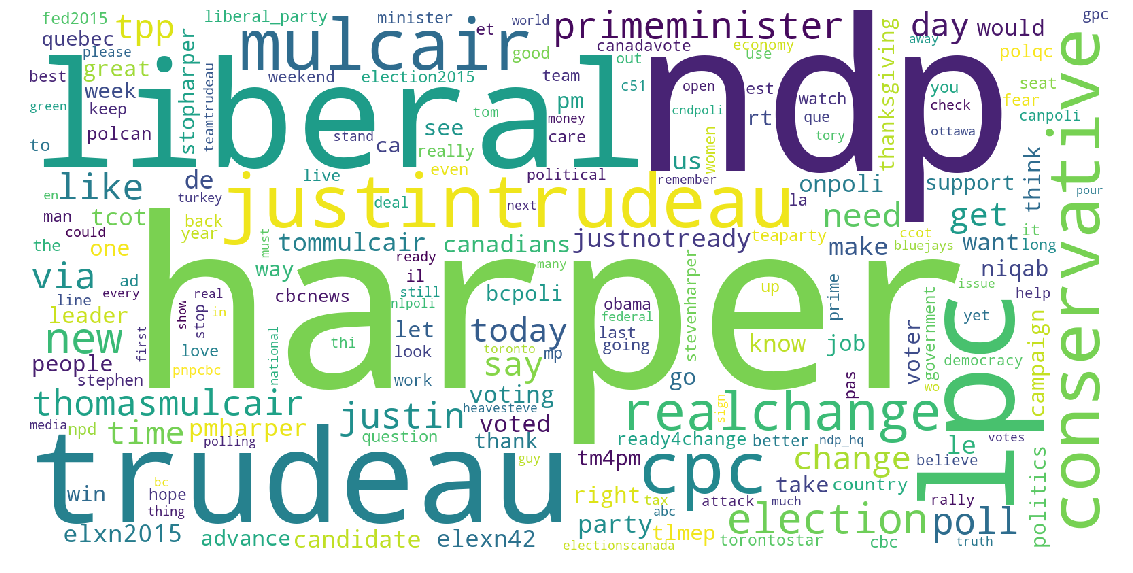

In [9]:
### UNCLASSIFIED DATA ###

# form keyword cloud after removing hashtags
wordsList = [] 
for index, row in ucTweets.iterrows():
    twords = row['tweet'].split(" ")
    wordsList = wordsList + twords
    
# # plot cloud 
wordcloud = WordCloud(width=1600, height=800, stopwords=['retweeted', 'vote', 'added', 'canadian', 'canada', 'cdnpoli', 'elxn42'],background_color='white',collocations=False).generate(" ".join(wordsList))
plt.figure( figsize=(20,10) ) 
plt.imshow(wordcloud)
plt.axis('off')
plt.show()  

From the word cloud, we can clearly see that the most of the people are talking about **Stephen Harper** and **Justin Trudeau**. People are referencing 'liberals' more than the conservatives but we can't comment anything on the regarding the likelihood of the potential candidate without actually performing **sentiment analysis**


We will now try to explore **Classified Data**

In [10]:
### CLASSIFIED DATA ###

# fetch classsified data
cTweets = pd.read_csv('classified_tweets.txt')

# cleanup tweet
cTweets["tweet"] = cTweets["text"].apply(cleanupTweet)

# debug
cTweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 7 columns):
class    200000 non-null int64
id       200000 non-null int64
date     200000 non-null object
query    200000 non-null object
user     200000 non-null object
text     200000 non-null object
tweet    200000 non-null object
dtypes: int64(2), object(5)
memory usage: 10.7+ MB


In [11]:
# show raw data
cTweets.head()

,class,id,date,query,user,text,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",@switchfoot awww bummer shoulda got david carr...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset ca update facebook texting it might cry ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,@kenichan dived many times ball managed save 5...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole body feels itchy like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",@nationwideclass no behaving all mad here ca s...


In [12]:
# remove unwanted columns like NO_QUERY, etc
cTweets = cTweets.drop(cTweets.columns[[1, 2, 3, 4, 5]], axis=1)

# debug
cTweets.head()

,class,tweet
0,0,@switchfoot awww bummer shoulda got david carr...
1,0,upset ca update facebook texting it might cry ...
2,0,@kenichan dived many times ball managed save 5...
3,0,whole body feels itchy like fire
4,0,@nationwideclass no behaving all mad here ca s...


Text(0,0.5,'Number of Tweets')

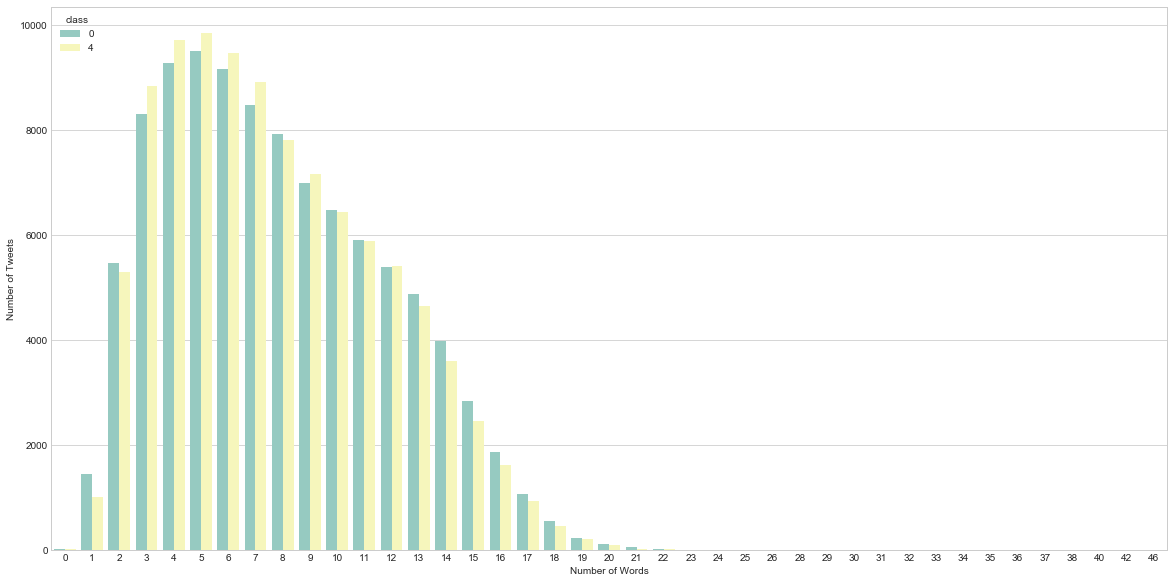

In [13]:
### CLASSIFIED DATA ### 
fig = plt.figure(figsize=(20,10))
cTweets['length'] = cTweets['tweet'].apply(lambda x : len(x.split()))
fig, axis1 = plt.subplots(1,1,figsize=(20,10))
sns.countplot(x='length', data=cTweets, hue="class", ax=axis1 ,palette="Set3")
plt.xlabel('Number of Words')
plt.ylabel('Number of Tweets')

The distributions for both positive and negative are almost similar which means that the data is very well distributed over the number of words in a similar fashion for both negative and positive tweets.

### Part 3. Model Preparation

To prepare the model, following fetaures are extracted from the classfied dataset.

1. **numTotalWords**: Number of total words in the tweet.
2. **lengthString**: Length of the string after 'clean up' operation.
3. **numHasTags**: Number of hashtags present in the tweet.
4. **numUserTags**: Number of user tags present in the tweet.
5. **numNoun**: Frequency of Nouns present in the tweet.
6. **numVerbs**: Frequency of verbs present in the tweet.
7. **numAdverb**: Frequency of adverb present in the tweet.
8. **numAdjective**: Frequency of adjective present in the tweet.

***Note: Pos Tagging is a slow step and takes around 200 seconds to complete***


In [14]:
'''This function extract POS Tag from the string using NLTK library'''
def posTag(tweet):
    
    # tokenize 
    words = word_tokenize(tweet)
    
    # do pos tagging
    tweetTags = pos_tag(words)
    
    #count freq
    noun = 0
    verb = 0
    adjective = 0
    adverb = 0
    for tag in tweetTags:
        if(tag[1] in ['NN', 'NNP', 'NNS']):
            noun += 1
        if(tag[1] in ['VB', 'VBD', 'VBN', 'VBG', 'VBZ', 'VBP']):
            verb += 1
        if(tag[1] in ['JJ', 'JJR', 'JJS']):
            adjective += 1
        if(tag[1] in ['RB', 'RBR', 'RBS']):
            adverb += 1
    
    # return 
    return noun, verb, adjective, adverb

'''prepare model by adding more features to the dataframe'''
def modelFeatures(tweetsList):
    
    # features
    tweetsList['length'] = tweetsList['tweet'].apply(len)
    tweetsList['numWords'] = tweetsList['tweet'].apply(lambda x: len(x.split()))
    tweetsList['numHashTags'] = tweetsList['tweet'].apply(lambda x: x.count('#'))
    tweetsList['numUserTags'] = tweetsList['tweet'].apply(lambda x: x.count('@'))
    tweetsList['tags'] = tweetsList['tweet'].apply(posTag)
    tweetsList['numNoun'] = tweetsList['tags'].apply(lambda x: x[0])
    tweetsList['numVerbs'] = tweetsList['tags'].apply(lambda x: x[1])
    tweetsList['numAdjective'] = tweetsList['tags'].apply(lambda x: x[2])
    tweetsList['numAdverbs'] = tweetsList['tags'].apply(lambda x: x[3])
 
    # remove tag columns & return
    return tweetsList.drop(['tweet', 'tags'], axis=1)
    
# model features
cTweets = modelFeatures(cTweets)

# debug
cTweets.head() 

,class,length,numWords,numHashTags,numUserTags,numNoun,numVerbs,numAdjective,numAdverbs
0,0,61,11,0,1,5,2,4,0
1,0,75,13,0,0,4,5,0,1
2,0,63,11,0,1,5,6,1,0
3,0,32,6,0,0,3,1,1,0
4,0,54,9,0,1,2,2,1,2


#### [BONUS] Correlational Analysis 
We are finished with adding new variables to the data, so now we can check the overall correlations by plotting the seaborn heatmap:

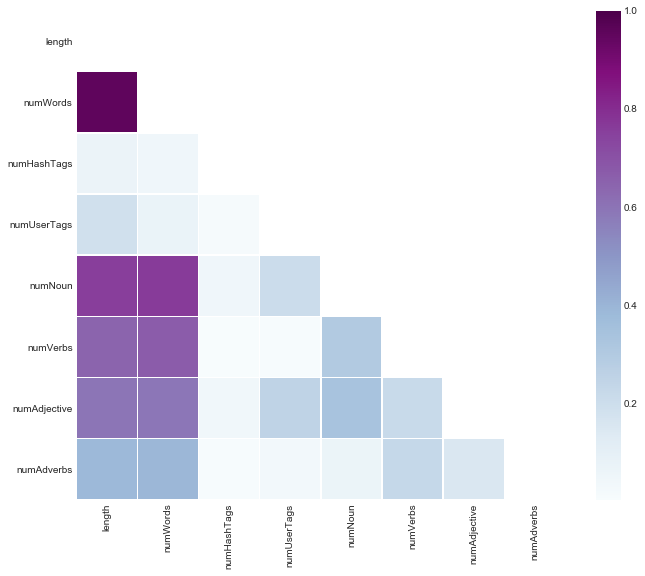

In [15]:
# Compute the correlation matrix  
corr_all = cTweets.drop('class', axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask, square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()

Here, we can see a strong correlation between the length of tweet and number of words which is obvious as tweet having more number of words will definitely be longer. 

### Part 4. Model Implementation

#### Splitting features/target variables
First, we will extract our features into the variable X, and our target into the variable y.

In [16]:
# prepare data for logistic regression
X = cTweets.loc[:, (cTweets.columns != 'class')] 
y = cTweets['class'] 

#### Splitting the dataset into training/testing sets
Now we will split the set into a training and testing set using the sklearn's train_test_split function.

In [17]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

#### Training the model
Now, we will use our training set to train (fit) a Logistic Regression model 

In [18]:
# prepare model
model = LogisticRegression()
model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### Prediction & Accuracy of Classified Data
we will now measure the accuracy of the test and train data

In [19]:
# predict train set
trainAccuracy = 100 * accuracy_score(y_train, model.predict(X_train))
testAccuracy = 100 * accuracy_score(y_test, model.predict(X_test))

#debug
print ('Train & Test Accuracy of Classified Data is: ', round(trainAccuracy, 2), ' & ', round(testAccuracy, 2), '\n')

# classification report
print(classification_report(y_test,model.predict(X_test)))

# store results
modelResults = [{
    'model': 'Logistic Regression',
    'trainAccuracy': trainAccuracy,
    'testAccuracy': testAccuracy
}] 

Train & Test Accuracy of Classified Data is:  60.0  &  59.88 

             precision    recall  f1-score   support

          0       0.59      0.65      0.62     29851
          4       0.61      0.55      0.58     30149

avg / total       0.60      0.60      0.60     60000



Classification report is pretty good as the precision is not lean towards any specific class.

#### [BONUS] Evaluating the model with Other Classifiers
1. Naive Bayes Classifier
2. Random Forest Classifier
3. Decision Tree Classifier

In [20]:
#### Naive Bayes Classification ####
gnb = GaussianNB()

# Train the model using the training sets 
gnb.fit(X_train, y_train)  
 
# store results
modelResults.append({
    'model': 'Naive Bayes',
    'trainAccuracy': (100 * accuracy_score(y_train, gnb.predict(X_train))),
    'testAccuracy': (100 * accuracy_score(y_test, gnb.predict(X_test)))
})

#### random forest classifier.  ####
clf = RandomForestClassifier() 
 
# Fit the selected classifier to the training data
clf.fit(X_train, y_train)

# store results
modelResults.append({
    'model': 'Random Forest',
    'trainAccuracy': (100 * accuracy_score(y_train, clf.predict(X_train))),
    'testAccuracy': (100 * accuracy_score(y_test, clf.predict(X_test)))
})

#### Decision Tree classifier.  ####
dt = DecisionTreeClassifier()

# Fit the selected classifier to the training data
dt.fit(X_train, y_train)

# store results
modelResults.append({
    'model': 'Decision Tree',
    'trainAccuracy': (100 * accuracy_score(y_train, dt.predict(X_train))),
    'testAccuracy': (100 * accuracy_score(y_test, dt.predict(X_test)))
})

Text(24.1139,0.5,'Accuracy in %')

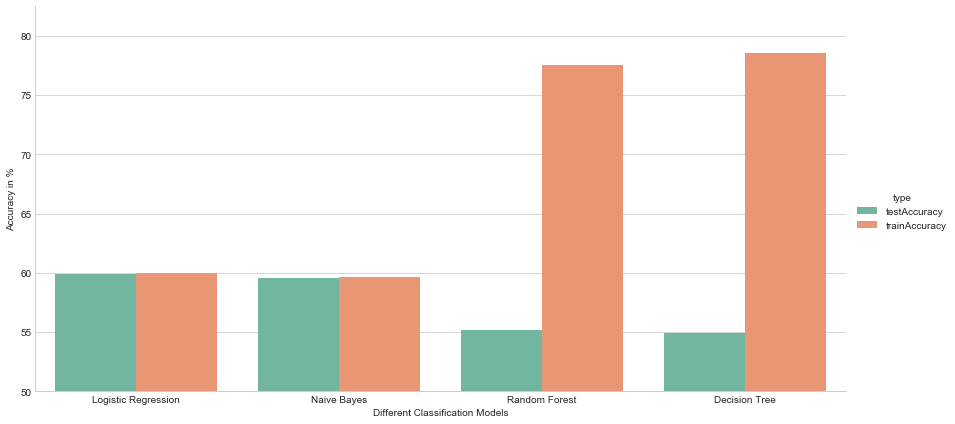

In [21]:
#plot results from the multiple classfiers
testResults = pd.DataFrame(modelResults)
testResults = pd.melt(testResults, id_vars="model", var_name="type", value_name="Accuracy")

# plot bar chart
fp = sns.factorplot(x='model', y='Accuracy', hue='type', data=testResults, kind='bar', size=6, aspect=2.0, palette="Set2")
fp.axes[0,0].set_ylim(50,)
plt.xlabel('Different Classification Models')
plt.ylabel('Accuracy in %')

**Decision Tree** performs significantly better on the train data while it performs worst on test data with 54% accuracy. **Logistic Regression** performs well on the test data set with ~60% accuracy.

#### Modelling & Prediction of Unclassified Data
we will now predict the unclassified data

In [22]:
# remove unwanted columns
try:
    X = ucTweets.drop(['isLiberal', 'isConservative', 'isDemocratic', 'isGreen', 'politicalParty'], axis=1)
except ValueError:
    print('error')

#unclassified tweets
X = modelFeatures(X) 

# make predictions
ucTweets['class'] = model.predict(X)

# debug
ucTweets.head()

,tweet,isLiberal,isConservative,isDemocratic,isGreen,politicalParty,class
0,living dream #cameraman #camera #cameraception...,0,0,1,0,Democratic,4
1,justin #trudeau reasons thanksgiving today mon...,2,0,0,0,Liberal,4
2,@themadape butt butt we allergic latex makes u...,0,0,0,0,None,4
3,massive explosions peace march #turkey 30 kill...,0,0,0,0,None,4
4,#mulcair suggests bad blood #trudeau #ready4ch...,1,0,2,0,Democratic,4


Text(8.28988,0.5,'Number of Tweets')

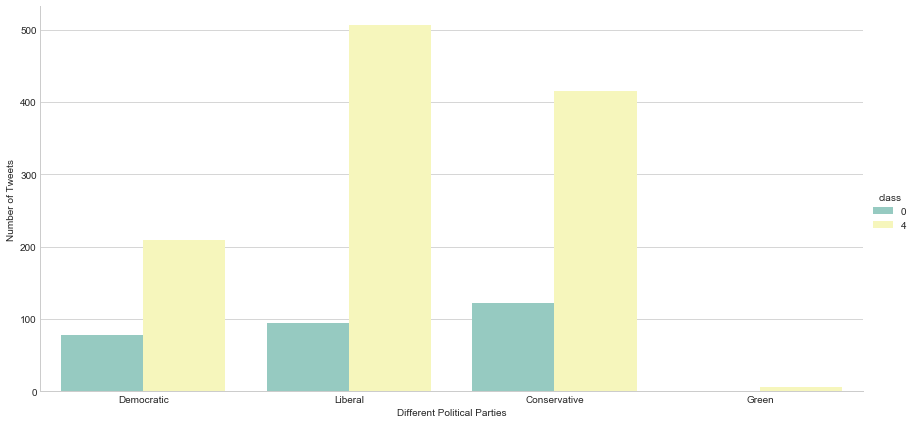

In [23]:
# plot
sns.factorplot(x="politicalParty", hue="class", data=ucTweets[ucTweets['politicalParty'] != 'None'], kind="count", size=6, aspect=2, palette="Set3")
plt.xlabel('Different Political Parties')
plt.ylabel('Number of Tweets')

By looking at the graph, we can say that most of the people favour **Liberals** as their sentiments towards them is very positive as compared to Conservative. Also, at the same time, liberals are more talked about in tweets. **Positive** to **Negative** sentiments ratio for liberal is higher than Conservative.

Looking at the **Green Party**, they are not very much associated with negative sentiments but they are not that popular as compared to Liberal and conservartive. 

Wordcloud for each class of sentiment for all the political parties is plotted as follows:

- BLACK Wordcloud: represents negative Sentiment 
- WHITE Wordcloud: represents positive Sentiment 

#### Liberal Party


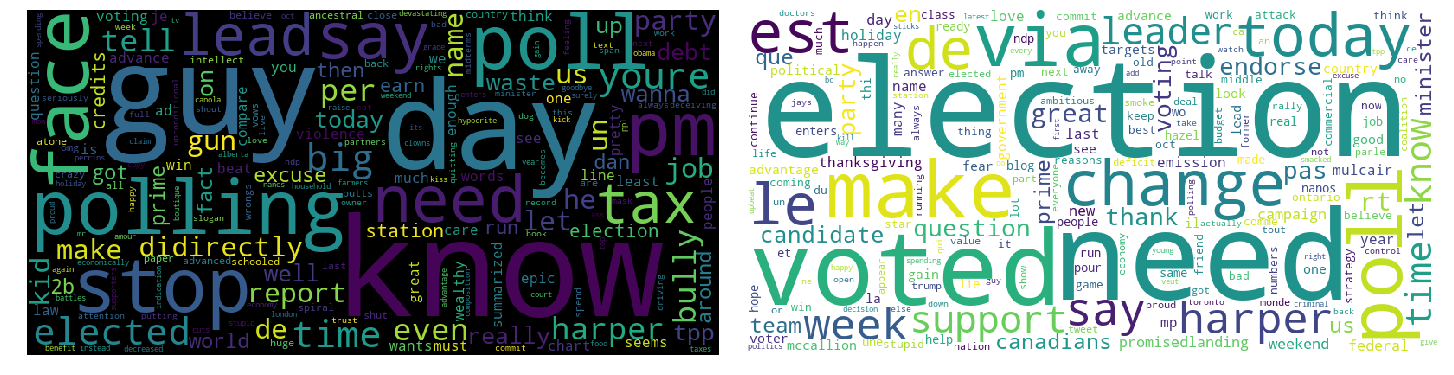

In [24]:
# plot word cloud
def plotWordCloud(color, wordsList, swords):
    wordcloud = WordCloud(
        width=800, height=400, background_color=color,
        stopwords=swords, collocations=False).generate(" ".join(wordsList))
    plt.imshow(wordcloud)
    plt.tight_layout(pad=0)
    plt.axis('off') 

#getWordList
def getWordList(data):
    wordsList = [] 
    for t in data:
        wordsList = wordsList + ([i for i in (t.split()) if ("#" not in i and "@" not in i )])
    return wordsList

# form swords
liberalList = ['want', 'justin', 'trudeau', 'justintrudeau', 'liberal', 'retweeted','going', 'get', 'go', 'vote', 'added', 'canadian', 'canada', 'cdnpoli', 'elxn42', 'like', 'would', 'liberals']
conservativeList = ['harper', 'stephen', 'conservative', 'conservatives', 'cpc','going', 'get', 'go', 'canadians', 'retweeted', 'vote', 'added', 'canadian', 'canada', 'cdnpoli', 'elxn42', 'like', 'would']
democraticList = ['mulcair', 'democratic', '#ndp', '#ptndp', 'retweeted', 'vote','going', 'get', 'go', 'added', 'canadian', 'canada', 'cdnpoli', 'elxn42', 'like', 'would']
greenList = ['elizabethmay', '#ptgreen', '#gpc', '#greens', 'retweeted', 'vote', 'going', 'get', 'go','added', 'canadian', 'canada', 'cdnpoli', 'elxn42', 'like', 'would']

# Liberal
plt.figure( figsize=(20,10)) 
plt.subplot(1, 2, 1)
plotWordCloud('black', getWordList(ucTweets[(ucTweets['politicalParty'] == 'Liberal') & (ucTweets['class'] == 0)].tweet.tolist()), liberalList)
plt.subplot(1, 2, 2)
plotWordCloud('white', getWordList(ucTweets[(ucTweets['politicalParty'] == 'Liberal') & (ucTweets['class'] == 4)].tweet.tolist()), liberalList)
plt.show()


From wordcloud of Liberals, we might say that things that are bothering people are more related to **bully**, **job**, 
**tax**, etc. 

#### Conservative Party

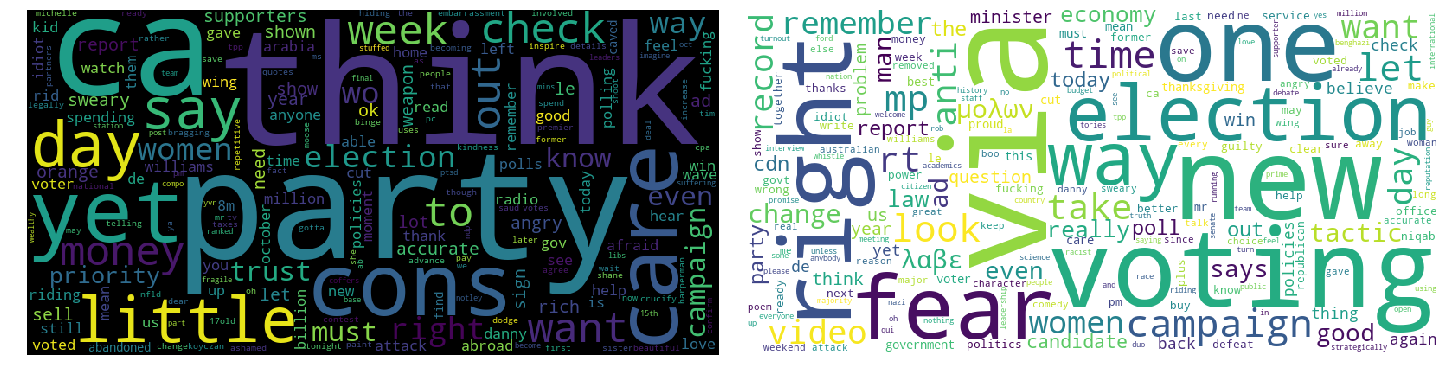

In [25]:
# Conservative
plt.figure( figsize=(20,10))
plt.subplot(1, 2, 1)
plotWordCloud('black', getWordList(ucTweets[(ucTweets['politicalParty'] == 'Conservative') & (ucTweets['class'] == 0)].tweet.tolist()), conservativeList)
plt.subplot(1, 2, 2)
plotWordCloud('white', getWordList(ucTweets[(ucTweets['politicalParty'] == 'Conservative') & (ucTweets['class'] == 4)].tweet.tolist()), conservativeList)
plt.show()


It looks like for conservatives, the pain points are related to **money**, **women**, etc.

#### New Democratic Party

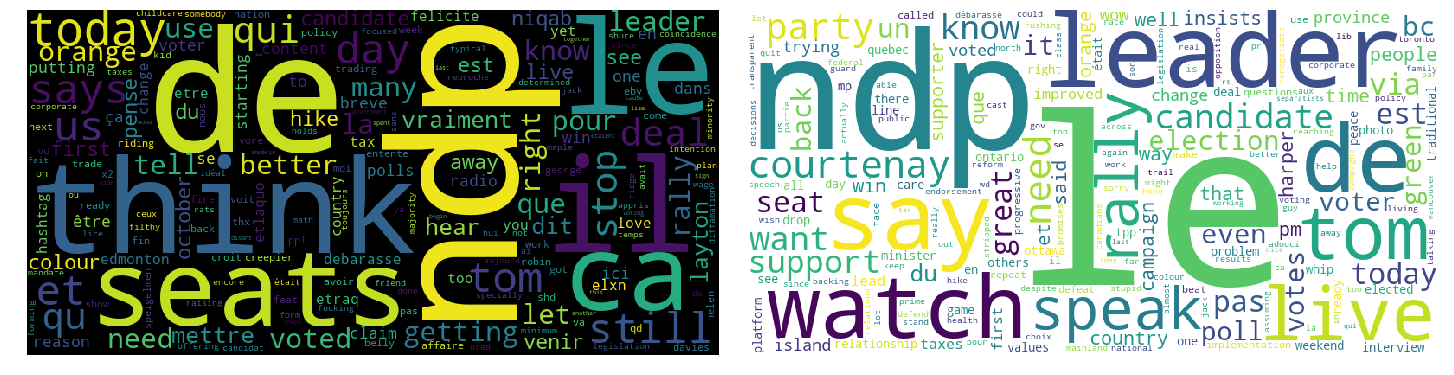

In [26]:
# Democratic
plt.figure( figsize=(20,10))
plt.subplot(1, 2, 1)
plotWordCloud('black', getWordList(ucTweets[(ucTweets['politicalParty'] == 'Democratic') & (ucTweets['class'] == 0)].tweet.tolist()), democraticList)
plt.subplot(1, 2, 2)
plotWordCloud('white', getWordList(ucTweets[(ucTweets['politicalParty'] == 'Democratic') & (ucTweets['class'] == 4)].tweet.tolist()), democraticList)
plt.show()


By looking at the word clouds of democratic party, it can be said that this party is quite popular in french dominated regions as most of the keywords are in french. 